In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# Import some useful packages for this homework
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset # "ConcatDataset" and "Subset" are possibly useful.
from torchvision.datasets import DatasetFolder, VisionDataset
from torchsummary import summary
from tqdm.auto import tqdm
import random

In [2]:
cfg = {
    'dataset_root': './data/food11-hw13',
    'save_dir': './hw13',
    'exp_name': "simple_baseline",
    'batch_size': 64,
    'lr': 3e-4,
    'seed': 20220013,
    'loss_fn_type': 'KD', # simple baseline: CE, medium baseline: KD. See the Knowledge_Distillation part for more information.
    'weight_decay': 5e-5,
    'grad_norm_max': 10,
    'n_epochs': 90,
    'patience': 300,
}

In [3]:
myseed = cfg['seed']  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
random.seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

save_path = os.path.join(cfg['save_dir'], cfg['exp_name']) # create saving directory
os.makedirs(save_path, exist_ok=True)

# define simple logging functionality
log_fw = open(f"{save_path}/log.txt", 'w') # open log file to save log outputs
def log(text):     # define a logging function to trace the training process
    print(text)
    log_fw.write(str(text)+'\n')
    log_fw.flush()

log(cfg)  # log your configs to the log file

{'dataset_root': './data/food11-hw13', 'save_dir': './hw13', 'exp_name': 'simple_baseline', 'batch_size': 64, 'lr': 0.0003, 'seed': 20220013, 'loss_fn_type': 'KD', 'weight_decay': 5e-05, 'grad_norm_max': 10, 'n_epochs': 90, 'patience': 300}


In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# define training/testing transforms
test_tfm = transforms.Compose([
    # It is not encouraged to modify this part if you are using the provided teacher model. This transform is stardard and good enough for testing.
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_tfm = transforms.Compose([
    # add some useful transform or augmentation here, according to your experience in HW3.
    transforms.Resize(256),  # You can change this
    transforms.RandomCrop(224), # You can change this, but be aware of that the given teacher model's input size is 224.
    # The training input size of the provided teacher model is (3, 224, 224).
    # Thus, Input size other then 224 might hurt the performance. please be careful.
    transforms.RandomHorizontalFlip(), # You can change this.
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(10),
    
    transforms.ToTensor(),
    normalize,
])

In [5]:
class FoodDataset(Dataset):
    def __init__(self, path, tfm=test_tfm, files = None):
        super().__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        try:
            label = int(fname.split("\\")[-1].split("_")[0])
        except:
            label = -1 # test has no label
        return im,label

In [6]:
train_set = FoodDataset(os.path.join(cfg['dataset_root'],"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=cfg['batch_size'], shuffle=True)

valid_set = FoodDataset(os.path.join(cfg['dataset_root'], "validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=cfg['batch_size'], shuffle=False)

One ./data/food11-hw13\training sample ./data/food11-hw13\training\0_0.jpg
One ./data/food11-hw13\validation sample ./data/food11-hw13\validation\0_0.jpg


In [7]:
# Example implementation of Depthwise and Pointwise Convolution 
def dwpw_conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels, kernel_size, stride=stride, padding=padding, groups=in_channels), #depthwise convolution
        nn.Conv2d(in_channels, out_channels, 1), # pointwise convolution
    )

In [8]:
class FireBlock(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(FireBlock, self).__init__()
        
        # Squeeze layer
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        
        # Expand layers
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        out = self.squeeze(x)
        out = self.squeeze_activation(out)
        expand1x1 = self.expand1x1(out)
        expand1x1 = self.expand1x1_activation(expand1x1)
        expand3x3 = self.expand3x3(out)
        expand3x3 = self.expand3x3_activation(expand3x3)
        
        out = torch.cat([expand1x1, expand3x3], dim=1)  # 在通道维度上拼接
        return out


In [9]:
w = 224
f = 3
p = 1
s = 2
(w-f+2*p)/s + 1

112.5

In [10]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = dwpw_conv(in_channels, out_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        out = self.bn(x)
        out = F.relu(out)
        out = self.conv(out)
        out = torch.cat((x, out), dim=1)  # 将当前输入和输出在通道维度上拼接
        return out

# 定义DenseNet网络
class DenseNet(nn.Module):
    def __init__(self, in_channels, num_classes, growth_rate=6, num_blocks=3, basic_block=6):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        num_channels = 64
        self.dense_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.dense_blocks.append(self._make_dense_block(num_channels, growth_rate, basic_block))
            num_channels += growth_rate*(basic_block)
        
        self.convdp = dwpw_conv(64+num_blocks*basic_block*growth_rate, (64+num_blocks*basic_block*growth_rate)//3, kernel_size=3, padding=1)
        self.bn_final = nn.BatchNorm2d(64+num_blocks*basic_block*growth_rate)
        self.bn_final_ = nn.BatchNorm2d((64+num_blocks*basic_block*growth_rate)//3)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear((64+num_blocks*basic_block*growth_rate)//3, num_classes)
    
    def _make_dense_block(self, in_channels, growth_rate, num_block):
        layers = []
        for i in range(num_block):  # 每个Dense Block包含4个Basic Block
            layers.append(BasicBlock(in_channels, growth_rate))
            in_channels += growth_rate
        layers.append(nn.Conv2d(in_channels,in_channels,1,1))
        layers.append(nn.AvgPool2d(2, 2, 0))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.pool(out)
        
        for block in self.dense_blocks:
            out = block(out)
        
        out = self.bn_final(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.convdp(out)
        out = self.bn_final_(out)
        out = F.avg_pool2d(out, kernel_size=7)  # 全局平均池化层
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [11]:
ckpt_path = f"{save_path}/student_best.ckpt" # the ckpt path of the best student model.
student_model = DenseNet(in_channels=3, num_classes=11)
# student_model.load_state_dict(torch.load(ckpt_path, map_location='cpu')) # load the state dict and set it to the student model
summary(student_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
       BatchNorm2d-4           [-1, 64, 56, 56]             128
            Conv2d-5           [-1, 64, 56, 56]             640
            Conv2d-6            [-1, 6, 56, 56]             390
        BasicBlock-7           [-1, 70, 56, 56]               0
       BatchNorm2d-8           [-1, 70, 56, 56]             140
            Conv2d-9           [-1, 70, 56, 56]             700
           Conv2d-10            [-1, 6, 56, 56]             426
       BasicBlock-11           [-1, 76, 56, 56]               0
      BatchNorm2d-12           [-1, 76, 56, 56]             152
           Conv2d-13           [-1, 76, 56, 56]             760
           Conv2d-14            [-1, 6,

In [13]:
# Load provided teacher model (model architecture: resnet18, num_classes=11, test-acc ~= 89.9%)
teacher_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=11)
# load state dict
teacher_ckpt_path = os.path.join(cfg['dataset_root'], "resnet18_teacher.ckpt")
teacher_model.load_state_dict(torch.load(teacher_ckpt_path))
# Now you already know the teacher model's architecture. You can take advantage of it if you want to pass the strong or boss baseline. 
# Source code of resnet in pytorch: (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)
# You can also see the summary of teacher model. There are 11,182,155 parameters totally in the teacher model
# summary(teacher_model, (3, 224, 224), device='cpu')

Using cache found in C:\Users\hasaki/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\hasaki\Desktop\machine-learning\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hasaki\Desktop\machine-learning\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [14]:
def loss_fn_kd(student_logits, labels, teacher_logits, alpha=0.5, temperature=1):
    # Apply Softmax to student and teacher logits
    student_probs = nn.Softmax(dim=1)(student_logits / temperature)
    teacher_probs = nn.Softmax(dim=1)(teacher_logits / temperature)
    
    # Calculate the KL divergence loss
    kd_loss = nn.KLDivLoss()(student_probs, teacher_probs)
    
    # Calculate the CrossEntropy loss
    ce_loss = nn.CrossEntropyLoss()(student_logits, labels)
    
    # Combine the two losses with the specified weights
    loss = alpha * pow(temperature, 2) * kd_loss + (1 - alpha) * ce_loss
    
    return loss


In [15]:
# choose the loss function by the config
if cfg['loss_fn_type'] == 'CE':
    # For the classification task, we use cross-entropy as the default loss function.
    loss_fn = nn.CrossEntropyLoss() # loss function for simple baseline.

if cfg['loss_fn_type'] == 'KD': # KD stands for knowledge distillation
    loss_fn = loss_fn_kd # implement loss_fn_kd for the report question and the medium baseline.

# You can also other types of knowledge distillation techniques, but use function name other than `loss_fn_kd`
# For example:
# def loss_fn_custom_kd():
#     pass
# if cfg['loss_fn_type'] == 'custom_kd':
#     loss_fn = loss_fn_custom_kd

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
log(f"device: {device}")

# The number of training epochs and patience.
n_epochs = cfg['n_epochs']
patience = cfg['patience'] # If no improvement in 'patience' epochs, early stop

device: cuda


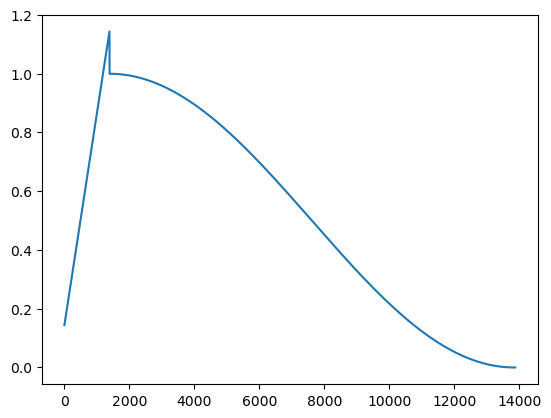

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import LambdaLR

optimizer = torch.optim.Adam(student_model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay']) 
warmup_alpth = 0.1
n = cfg["n_epochs"]*len(train_set)/64

def warmup_lr_lambda1(epoch):
    if epoch < warmup_alpth*n:
        return (epoch+200) / (warmup_alpth * n)
    else:
        return 1/2*math.cos((epoch-warmup_alpth*n)/n*3.5)+1/2
def warmup_lr_lambda2(epoch): 
    return pow(10,-2*epoch/n)

scheduler = LambdaLR(optimizer, lr_lambda=warmup_lr_lambda1)
li = [warmup_lr_lambda1(i) for i in range(math.floor(n))]
plt.plot(li)

In [17]:
# Initialize a model, and put it on the device specified.
student_model.to(device)
teacher_model.to(device) # MEDIUM BASELINE

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0.0

t_losses = []
t_accs = []

v_losses = []
v_accs = []

teacher_model.eval()  # MEDIUM BASELINE
for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    student_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    train_lens = []

    bar = tqdm(train_loader)
    for batch in bar:

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        with torch.no_grad():  # MEDIUM BASELINE
            teacher_logits = teacher_model(imgs)  # MEDIUM BASELINE
        
        logits = student_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
#         loss = loss_fn(logits, labels) # SIMPLE BASELINE
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=cfg['grad_norm_max'])

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        train_batch_len = len(imgs)
        train_loss.append(loss.item() * train_batch_len)
        train_accs.append(acc)
        train_lens.append(train_batch_len)
        bar.set_postfix(loss=f'{(sum(train_loss) / sum(train_lens)):.5f}',acc=f"{(sum(train_accs) / sum(train_lens)).item():.5f}")
        scheduler.step()
        
    train_loss = sum(train_loss) / sum(train_lens)
    train_acc = sum(train_accs) / sum(train_lens)
    
    t_losses.append(train_loss)
    t_accs.append(train_acc)
    
    
    # Print the information.
    log(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    student_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    valid_lens = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = student_model(imgs)
            teacher_logits = teacher_model(imgs) # MEDIUM BASELINE

        # We can still compute the loss (but not the gradient).
        loss = loss_fn(logits, labels, teacher_logits) # MEDIUM BASELINE
#         loss = loss_fn(logits, labels) # SIMPLE BASELINE

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().sum()

        # Record the loss and accuracy.
        batch_len = len(imgs)
        valid_loss.append(loss.item() * batch_len)
        valid_accs.append(acc)
        valid_lens.append(batch_len)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / sum(valid_lens)
    valid_acc = sum(valid_accs) / sum(valid_lens)
    
    v_losses.append(valid_loss)
    v_accs.append(valid_acc)

    # update logs
    
    if valid_acc > best_acc:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        log(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        log(f"Best model found at epoch {epoch}, saving model")
        torch.save(student_model.state_dict(), f"{save_path}/student_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            log(f"No improvment {patience} consecutive epochs, early stopping")
            break
log("Finish training")
log_fw.close()

  0%|          | 0/155 [00:00<?, ?it/s]

C:\Users\hasaki\Desktop\machine-learning\env\lib\site-packages\torch\nn\functional.py:2916: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[ Train | 046/090 ] loss = 1.12812, acc = 0.21589


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 046/090 ] loss = 1.05711, acc = 0.30641 -> best
Best model found at epoch 45, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 047/090 ] loss = 1.04226, acc = 0.30793


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 047/090 ] loss = 0.99215, acc = 0.32945 -> best
Best model found at epoch 46, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 048/090 ] loss = 0.98045, acc = 0.33803


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 048/090 ] loss = 0.95186, acc = 0.33848 -> best
Best model found at epoch 47, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 049/090 ] loss = 0.93776, acc = 0.36469


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 049/090 ] loss = 0.92296, acc = 0.36647 -> best
Best model found at epoch 48, saving model


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 050/090 ] loss = 0.90374, acc = 0.37959


  0%|          | 0/54 [00:00<?, ?it/s]

[ Valid | 050/090 ] loss = 0.91528, acc = 0.36560


  0%|          | 0/155 [00:00<?, ?it/s]

[ Train | 051/090 ] loss = 0.87750, acc = 0.38993


  0%|          | 0/54 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.subplot(2, 1, 1)
for i in range(len(t_accs)):
    t_accs[i] = t_accs[i].cpu()
for i in range(len(v_accs)):
    v_accs[i] = v_accs[i].cpu()    
    
plt.title("acc")
plt.plot(t_accs,'-r')

plt.plot(v_accs,'-b')

plt.subplot(2, 1, 2)
plt.title("loss")
plt.plot(t_losses,'-r')

plt.plot(v_losses,'-b')

In [ ]:
# create dataloader for evaluation
eval_set = FoodDataset(os.path.join(cfg['dataset_root'], "evaluation"), tfm=test_tfm)
eval_loader = DataLoader(eval_set, batch_size=cfg['batch_size'], shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
# Load model from {exp_name}/student_best.ckpt
student_model_best = DenseNet(in_channels=3, num_classes=11) # get a new student model to avoid reference before assignment.
ckpt_path = f"{save_path}/student_best.ckpt" # the ckpt path of the best student model.
student_model_best.load_state_dict(torch.load(ckpt_path, map_location='cpu')) # load the state dict and set it to the student model
student_model_best.to(device) # set the student model to device

# Start evaluate
student_model_best.eval()
eval_preds = [] # storing predictions of the evaluation dataset

# Iterate the validation set by batches.
for batch in tqdm(eval_loader):
    # A batch consists of image data and corresponding labels.
    imgs, _ = batch
    # We don't need gradient in evaluation.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = student_model_best(imgs.to(device))
        preds = list(logits.argmax(dim=-1).squeeze().cpu().numpy())
    # loss and acc can not be calculated because we do not have the true labels of the evaluation set.
    eval_preds += preds

def pad4(i):
    return "0"*(4-len(str(i))) + str(i)

# Save prediction results
ids = [pad4(i) for i in range(0,len(eval_set))]
categories = eval_preds

df = pd.DataFrame()
df['Id'] = ids
df['Category'] = categories
df.to_csv(f"{save_path}/submission.csv", index=False) # now you can download the submission.csv and upload it to the kaggle competition.